# Cora Classification with SVGP

## Setup

In [1]:
import tensorflow as tf
import numpy as np
import scipy.special
import gpflow
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output
import networkx as nx
from gpflow.utilities import print_summary
import tensorflow_probability as tfp
import seaborn as sns
from tqdm import tqdm

import sys
import os
project_root = os.path.abspath("../..")
sys.path.append(project_root)

from efficient_graph_gp.graph_kernels import get_normalized_laplacian
from efficient_graph_gp.gpflow_kernels import GraphDiffusionFastGRFKernel, GraphDiffusionPoFMKernel, GraphDiffusionKernel, GraphGeneralPoFMKernel, GraphGeneralFastGRFKernel
from utils import compute_fro
from cora_utils.preprocessing import load_PEMS, load_cora

In [2]:
np.random.seed(123)
num_eigenpairs = 500
dataset = 'cora'
cls_number = 7
train_num = 140

In [3]:
G, data_train, data_test = load_cora(num_train=train_num, num_test=1000)
adjacency_matrix = nx.to_numpy_array(G) 
x_train, y_train = data_train
x_test, y_test = data_test

## Build PoFM Kernel

In [4]:
MAX_WALK_LENGTH = 3

In [5]:
graph_kernel = GraphGeneralPoFMKernel(adjacency_matrix,
                                      max_walk_length=MAX_WALK_LENGTH,
                                      normalize_laplacian=True)

In [6]:
likelihood = gpflow.likelihoods.MultiClass(num_classes=cls_number)

In [ ]:
# pick M inducing points
M = 140
Z = x_train[np.random.choice(train_num, M, replace=False)].copy()

model = gpflow.models.SVGP(
    kernel=graph_kernel,
    likelihood=likelihood,
    inducing_variable=Z,
    num_latent_gps=cls_number,
    whiten=True,
)

## Training

In [ ]:
# 3. Adam optimizer + minibatch pipeline
batch_size = 140 # full batch
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)) \
                         .shuffle(train_num).batch(batch_size).repeat()

opt = tf.optimizers.Adam(learning_rate=0.01)
num_steps = 1000
loss_history = []

In [9]:
train_iter = iter(train_ds)  # endless iterator
pbar = tqdm(range(num_steps), desc="Training SVGP", unit="step")

for step in pbar:
    Xb, Yb = next(train_iter)
    with tf.GradientTape() as tape:
        loss = model.training_loss((Xb, Yb))   # negative ELBO
    grads = tape.gradient(loss, model.trainable_variables)
    opt.apply_gradients(zip(grads, model.trainable_variables))

    # record the ELBO (positive) rather than its negative
    elbo = -loss.numpy()
    loss_history.append(elbo)

    # update the bar with the latest loss
    pbar.set_postfix(loss=f"{elbo:.3e}")

Training SVGP:   0%|          | 0/200 [00:00<?, ?step/s]/Users/matthew/Documents/Efficient Gaussian Process on Graphs/Efficient_Gaussian_Process_On_Graphs/venv/lib/python3.11/site-packages/keras/src/optimizers/base_optimizer.py:731: UserWarning: Gradients do not exist for variables ['Variable:0'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(
Training SVGP: 100%|██████████| 200/200 [07:04<00:00,  2.12s/step, loss=-7.477e+02]


In [10]:
# 5. Evaluate
from sklearn.metrics import accuracy_score
probs, _ = model.predict_y(x_test)
y_pred   = np.argmax(probs, axis=1)
acc      = accuracy_score(y_test, y_pred)
print(f"Test accuracy: {acc*100:.1f}%")

Test accuracy: 58.0%


In [12]:
model

name,class,transform,prior,trainable,shape,dtype,value
SVGP.kernel.modulator_vector,Parameter,Identity,,True,"(3,)",float64,[ 0.51659137 -0.94079004 0.39754024]
SVGP.likelihood.invlink.epsilon,Parameter,Sigmoid,Beta,False,(),float64,0.0010000000000000002
SVGP.inducing_variable.Z,Parameter,Identity,,True,"(50, 1)",float64,[[2461....
SVGP.q_mu,Parameter,Identity,,True,"(50, 7)",float64,"[[-3.19552562e-01, -3.19415207e-01, 1.92643000e+00..."
SVGP.q_sqrt,Parameter,FillTriangular,,True,"(7, 50, 50)",float64,"[[[7.72417023e-01, 0.00000000e+00, 0.00000000e+00..."


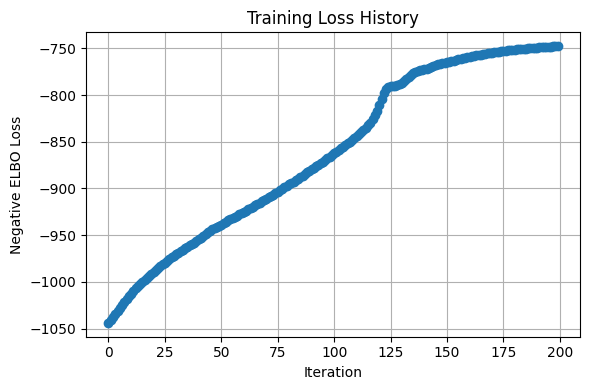

In [11]:
import matplotlib.pyplot as plt

# --- Plot 1: ELBO (actually negative loss) over iterations ---
plt.figure(figsize=(6,4))
plt.plot(loss_history, marker='o', linestyle='-')
plt.xlabel("Iteration")
plt.ylabel("Negative ELBO Loss")
plt.title("Training Loss History")
plt.grid(True)
plt.tight_layout()
plt.show()